<a href="https://colab.research.google.com/github/jasondrebber/GEOL558/blob/main/Unsupervised_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Project
## Jason Drebber
##### 1/18/2025
###### Earth Resource Data Science

I am utilizing data from the National Snow and Ice Data Center which includes an inventory of over 130,000 glaciers with 39 features including multiple identifiers assigned by different researchers, descriptors for each of the glaciers like depth, area, or mean elevation. The data is updated by various methods to have a complete inventory of all glaciers on the planet as well as the key features needed to understand each of these glaciers. For this project I am interested in generally exploring relationships in the data. What relationships exist among all of the worlds glaciers? How did different features co-vary? Are there obvious groups of glaciers that can be identified easily based on certain features of the data? I intend to apply a few of the unsupervised machine learning methods to investigate these questions and potentially answer others in the code and analysis below!

# Set-up

In [38]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import zipfile

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.metrics import silhouette_score

import warnings as wr
wr.filterwarnings("ignore")

In [39]:
# Access the API to load the data and save
!kaggle datasets download -d nsidcorg/glacier-inventory

with zipfile.ZipFile("glacier-inventory.zip", 'r') as zip_ref:
    zip_ref.extractall("glacier-inventory")

# Load the database file
wgi = pd.read_csv('/content/glacier-inventory/database.csv')

Dataset URL: https://www.kaggle.com/datasets/nsidcorg/glacier-inventory
License(s): CC0-1.0
glacier-inventory.zip: Skipping, found more recently modified local copy (use --force to force download)


# EDA and Cleansing

In [40]:
wgi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Glacier ID                   132890 non-null  object 
 1   Political Unit               132890 non-null  object 
 2   Continent                    132890 non-null  object 
 3   Basin Code                   132890 non-null  object 
 4   Location Code                132890 non-null  object 
 5   Glacier Code                 132890 non-null  object 
 6   Glacier Name                 46751 non-null   object 
 7   Latitude                     132890 non-null  float64
 8   Longitude                    132890 non-null  float64
 9   Primary Class                131406 non-null  float64
 10  Glacier Source               132746 non-null  float64
 11  Basin Count                  15558 non-null   float64
 12  Glacier Form                 131813 non-null  float64
 13 

The data here has 39 features but many of them are not useful for learning about glaciers (for example the Photograph year) or are indivually defined data that is not consistent across the whole dataset (such as the Location Code and Glacier Code which are defined in the metatdata), or columns which only store information about certain types of glaciers (Glacier activity and activity stary and end). Additionally some of the columns co-vary significantly and record essentially the same information, so can be reduced without significant loss of information (Minimum Elevation and Mean Elevation for example). I will remove some of these columns manually to select only the columns which are likely to have useful information for learning (this is supported by a review of the metatdata for this dataset availabel at https://nsidc.org/sites/default/files/g01130-v001-userguide_1_0.pdf)

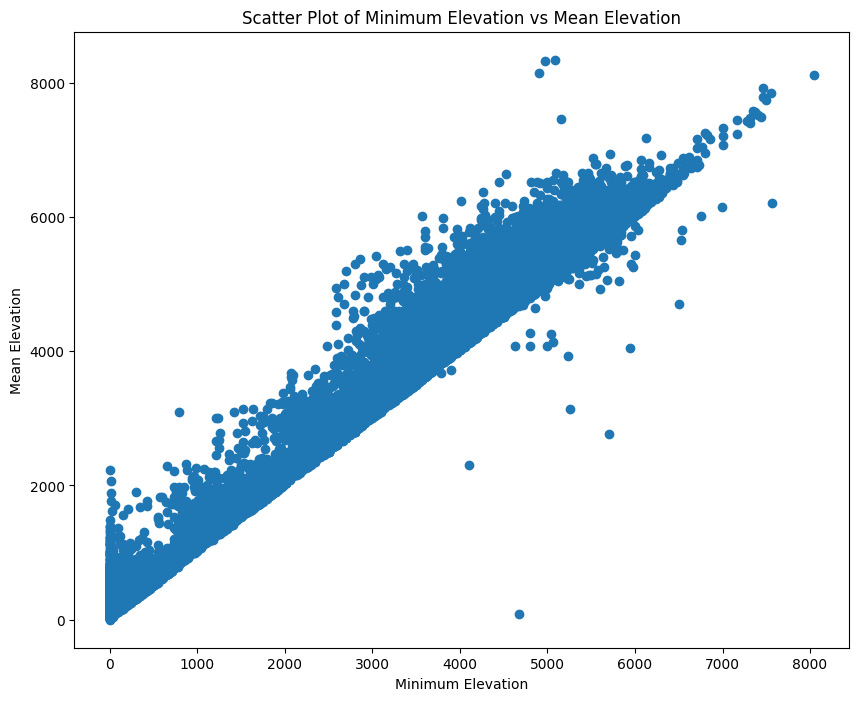

In [41]:
# Figure 1: scatter plot of the Mean elevation and Minimum elevation showing that they are highly correlated
# and removal of one will not result in loss of data due to the other remining in the data.

# This plot is an example of two features that are highly correlated and removal of one will not provide a
# a significant loss of data (This is manual dimensionality reduction based on domain expertise).
plt.figure(figsize=(10, 8))
plt.scatter(wgi['Minimum Elevation'], wgi['Mean Elevation'])
plt.xlabel('Minimum Elevation')
plt.ylabel('Mean Elevation')
plt.title('Scatter Plot of Minimum Elevation vs Mean Elevation')
plt.show()

For the final data I have decided to keep 7 total features with the goal to be understanding their relationship to the class of glacier or glacier type (see below for a description of each primary class). I kept latitude as as indicator of the glaciers location. These are important because glaciers are more common at higher latitudes (due to the cold required to preserve snow on their surface through the summer). Longitude is less indicative of anything since glaciers are present around most logitudinal locations and is somewhat arbitrary. I doubt it will result in any benefit to any models I construct. I kept the primary class feature which is the type of glacier (ice sheet, mountain glacier, valley glacier, etc; see below). I considered keeping the glacier form feature but it is essentially the same information as the glacier class but with more classes and felt unnecessary to have both. Additionally I suspect that it will be too indicative of the class as an interpretive feature. The last few features I kept are a number of numerical measurements of the glaciers. The first is Mean elevation. This dataset had 8 out of 39 features that were dedicated to the elevation. However after reviewing some of the data (fig 1) and considering the glaciology of the systems, most of these are recording the same information. For example the Mean elevation and the snow line elevation are generally within a few hundred meters or less because the snow line often forms near the mean elevation. I decided that the mean elevation was the best choice because it is most likely to be indicative of the entire range of elevations that the glacier exists at. I kept the glacier area which is an estimate usually from satellites that records the total surface area of a glacier. The maximum length is interesting because it can indicate the type of glacier, since a valley glacier is generally extnding through a valley then I thought this feature would be indicative of specific glacier types. Mean depth is the average thickness of the ice over the entire areal extent of the glacier. Finally the Accumulation oriention is the primary cardinal direction which the glacier gains mass by. This is often similar to the ablation orientation which is the primary cardinal direction a glacier loses mass by. However I dropped the ablation orientation here for simplicity. It is sometimes different for example in a valley glacier that starts facing north but the valley it is following winds to a different direction. One of these features is specifically important however because the orientation is generally known to be correlated to th esize and longeivty of a glacier so I suspect it will be important for understanding the tpyes of glaciers based on their features.

In [42]:
# Define which features to keep in the final data
wgi = wgi[['Latitude', 'Primary Class', 'Mean Elevation', 'Glacier Area', 'Maximum Length', 'Mean Depth', 'Accumulation Orientation']]


# Check out the glacier information again now that I have removed some of the columns
wgi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Latitude                  132890 non-null  float64
 1   Primary Class             131406 non-null  float64
 2   Mean Elevation            81599 non-null   float64
 3   Glacier Area              128374 non-null  float64
 4   Maximum Length            102593 non-null  float64
 5   Mean Depth                70071 non-null   float64
 6   Accumulation Orientation  114432 non-null  object 
dtypes: float64(6), object(1)
memory usage: 7.1+ MB


In [43]:
# Analyze the number of glaciers in each of the "Primary Classes"
wgi['Primary Class'].value_counts()

Primary Class
6.0    65042
7.0    35201
5.0    14002
0.0     8209
3.0     2752
9.0     2711
4.0     2532
2.0      682
1.0      267
8.0        8
Name: count, dtype: int64

The code above is assessing the possible target vector if this data was to be used for classification purposes. I would attempt to classify the class of glacier based on the other parameters. To explain each of these classes I will go into a bit of detail about the types of glaciers in descending order by counts in the available data.


Class 6 is Mountain Glaciers these generally tend to be small glaciers confined to high alpine mountainous terrain. They are often the last remnants of larger glaciers from previous glacial periods.

Class 7 is snowfields and glacierettes. These are even smaller features than mountain glaciers usually confined to hollows, river beds and protected slopes that prevent loss of snow in the summer. They are often not flowing, but must be present for at least 2 years to achieve this classification.

Class 5 is valley glaciers. These are what most people picture when they think of a glacier, they are large glaciers confined to valleys usually with a well defined catchment and boundary.

Class 0 is miscellaneous which means that they either arent classified or don't fit the conventional classifications.

Class 3 is ice caps these are smaller (less than 50,000 square km) radially flowing domes of ice that overly local topography.

Class 9 is Rock glaciers which are flowing masses of rocks which have an interstitial matrix of ice.

Class 4 are outlet glaciers. This type of glacier is extremely similar to a valley galcier except that they drain off of ice sheets (Greenland and Antarctica).

Class 2 is an icefield which is a collection of glaciers which all meet at a plateau but is not sufficient to overly the local topography meaning that glaciers flow constrained by the topography.

Class 1 is a continental ice sheet (Greenland and Antarctica are the only examples of this).

Class 8 is the floating extension of an ice sheet, meaning the portion of the ice that dislodges from the bed and begins floating on the ocean.

In [44]:
# Let's take a look at the data now to see what it actually looks like
print('The shape of the data is', wgi.shape)
wgi.tail()

The shape of the data is (132890, 7)


Latitude  Primary Class  Mean Elevation  Glacier Area  Maximum Length  \
132885     0.438            6.0             NaN          0.04             0.1   
132886     0.440            6.0             NaN          0.02             0.1   
132887     0.389            6.0          5030.0          0.02             0.1   
132888     0.389            6.0          4740.0          0.25             0.8   
132889     0.383            6.0          4700.0          0.42             0.7   

        Mean Depth Accumulation Orientation  
132885         NaN                      NaN  
132886         NaN                       NW  
132887         NaN                      NaN  
132888         NaN                        W  
132889         NaN                        W

In [45]:
# As you can see above there are some rows that have NaN values in them so in order to
# deal with processing the data better later I am going to remove these rows.
# First lets see how many NaN values are in each row.
print(wgi.isna().sum())

# Remove any row with no data
glaciers = wgi.dropna()
print("The new shape of the data is", glaciers.shape)

Latitude                        0
Primary Class                1484
Mean Elevation              51291
Glacier Area                 4516
Maximum Length              30297
Mean Depth                  62819
Accumulation Orientation    18458
dtype: int64
The new shape of the data is (51802, 7)


I performed the above data cleansing step because we don't want NaN values in the dataset when we are doing ML, so it was necessary to deal with those values. Given the nature of the dataset I did not want to impute values here because the variability between glaciers is so high I am worried about flooding the data with values that do not make sense, so this was a simple method to get rid of a large number of potentially not-useful data.

From a glaciological perspective this is appropriate because there are are large number of very small niche glaciers and glaciaretes in the world (included as Primary class 6 and 7) which have unique characteristics compared to the larger Valley and mountain glaciers people are familiar with (Primary Class 5 and 6). I intended to look at the larger glaciers in this analysis anyways. Let's do .value_counts() again to see how many of each class remain now that we removed NaNs.

Primary Class
6.0    23814
7.0    20430
5.0     3983
0.0     2670
4.0      421
9.0      324
3.0      152
2.0        8
Name: count, dtype: int64


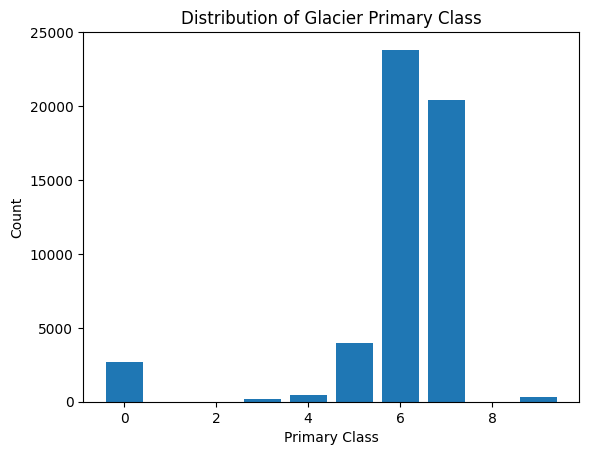

In [46]:
# Figure 2: Bar plot of the counts of each class of glacier included in the data.
# it is clear that hte data is dominated by the Mountain glacier and Glaciarette/Snowfield classes.

print(glaciers['Primary Class'].value_counts())
primary_class_counts = glaciers['Primary Class'].value_counts()
plt.bar(primary_class_counts.index, primary_class_counts.values)
plt.xlabel('Primary Class')
plt.ylabel('Count')
plt.title('Distribution of Glacier Primary Class')
plt.show()

Text(0.5, 1.0, 'Pairplot of the relationship between each data feature')

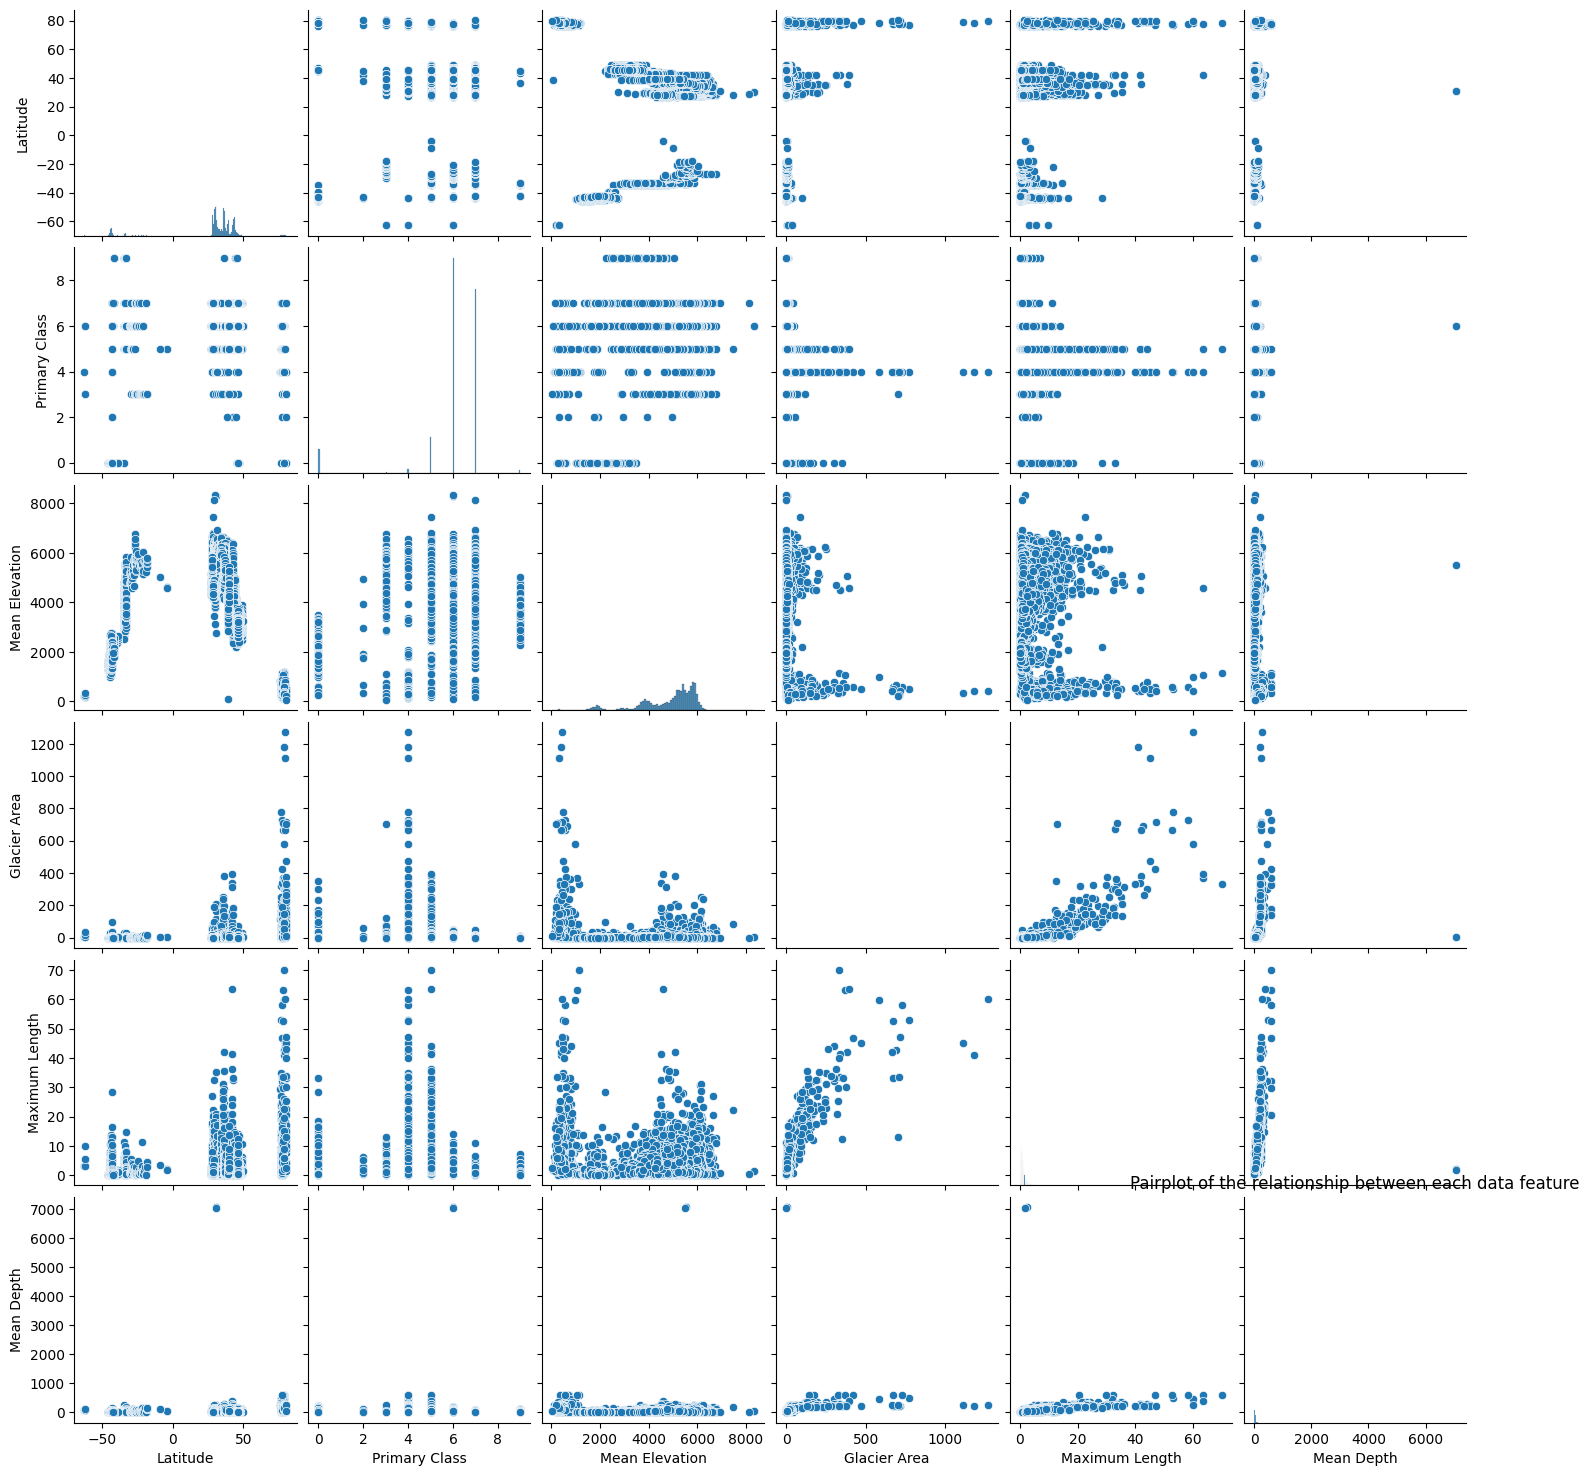

In [47]:
# Fig 3: Pair plot showing the scatter plot for the relationship between each of the accepted variables and each other.
sns.pairplot(glaciers)
plt.title("Pairplot of the relationship between each data feature")

There are a few trends I notice in this plot, first is that the minimum elevation appears to be related to the Latitude quite well, although it is not a linear relationship, at low latitudes the minimum elevation is higher than at the poles. This is consistent with common understanding of the temperature and galcier relationship. At high altitude it is colder due to atmosheric cooling so glaciers can survive even near the equator, whereas at high latitude they can suvive down at sea level. Additionally, the maximum length appears to have a non-linear relationship with the mean area, as the maximum length increases the area increases, but it increases faster for longer glaciers. The other feature I notice is in the histogram of glacier area which appears to be multimodal and I hypothesize that this is related to the different classes of glaciers.

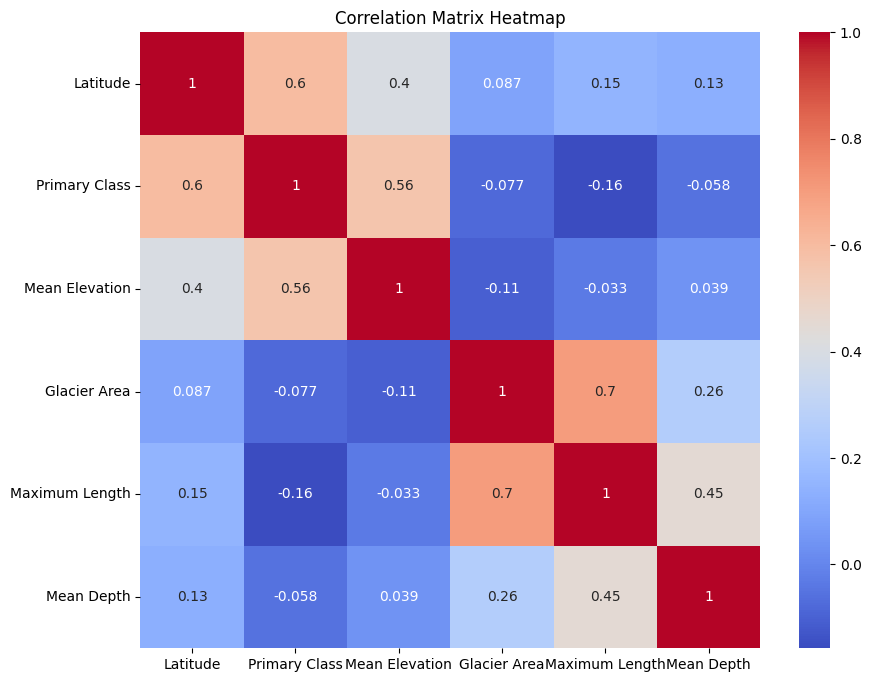

In [48]:
# Figure 4: Correlation heatmap of the different numeric values, where red is higher correlation and blue is low correlation.

# Calculate the correlation matrix, but only for numeric columns
corr_matrix = glaciers.select_dtypes(include=np.number).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

There are many interesting relationships indicated in the figures above. One thing is the lack of correlation between Glacier Latitude and minimu elevation which is related to the non-linear relationship they have. Ther do appear to be stonr relationships between Glacier area and maximum length as predicted from above as well as Mean elevation and Primary class. This one is interesting because I did not necessarily expect mean elevation and the class to be correlated like this. There is also a slightly strong relationship between the Mean Depth and Maximum Length of the glacier. There are not very strong negative linear relationships.

Text(0.5, 1.0, 'Scatter Plot of Glacier Depth vs. Area')

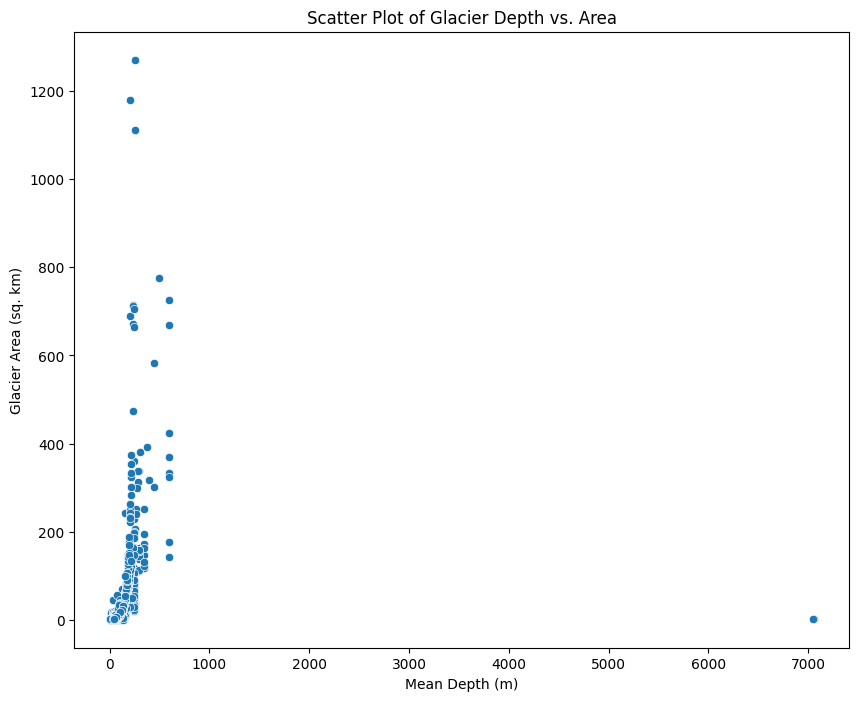

In [49]:
# Figure 5: Scatter plot of the relationship between area and depth in more detail. First thing I notice is an outlier which may affect
# the results later, so lets remove it. I know this is an outlier because there are no 7 km deep glaciers in the world.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Mean Depth', y='Glacier Area', data=glaciers)
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Scatter Plot of Glacier Depth vs. Area')

In [50]:
# Remove the obvious outlier
outliers = glaciers[glaciers['Mean Depth'] > 1000]
glaciers = glaciers.drop(outliers.index)

Text(0.5, 1.0, 'Scatter Plot of Glacier Depth vs. Area after removing outliers')

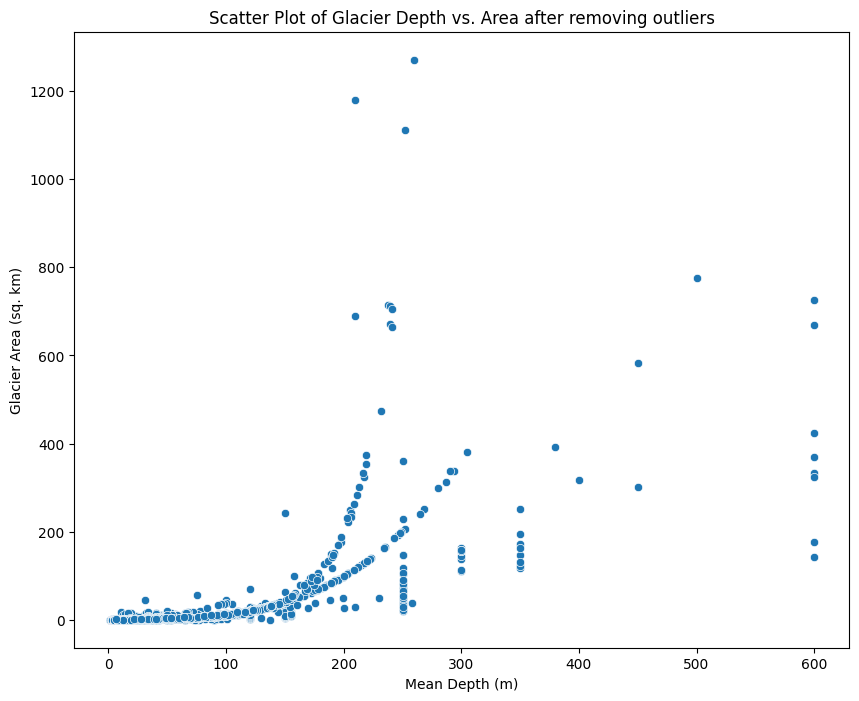

In [51]:
# Figure 6: Scatter plot of the relationship between area and depth after dropping the outlier.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Mean Depth', y='Glacier Area', data=glaciers)
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Scatter Plot of Glacier Depth vs. Area after removing outliers')

This is interesting. There appears to be three separate relationships (slopes) of the trend between the depth and area. There is a low slope realtionship that is more dispersed, a middle slope that is non-linear, and a high slope example that increases quickly with depth. This will be interesting to investigate, but suggests the presence of at least three clusters in the data.

Text(0.5, 1.0, 'Pairplot of the relationship between each data feature after removing the outlier')

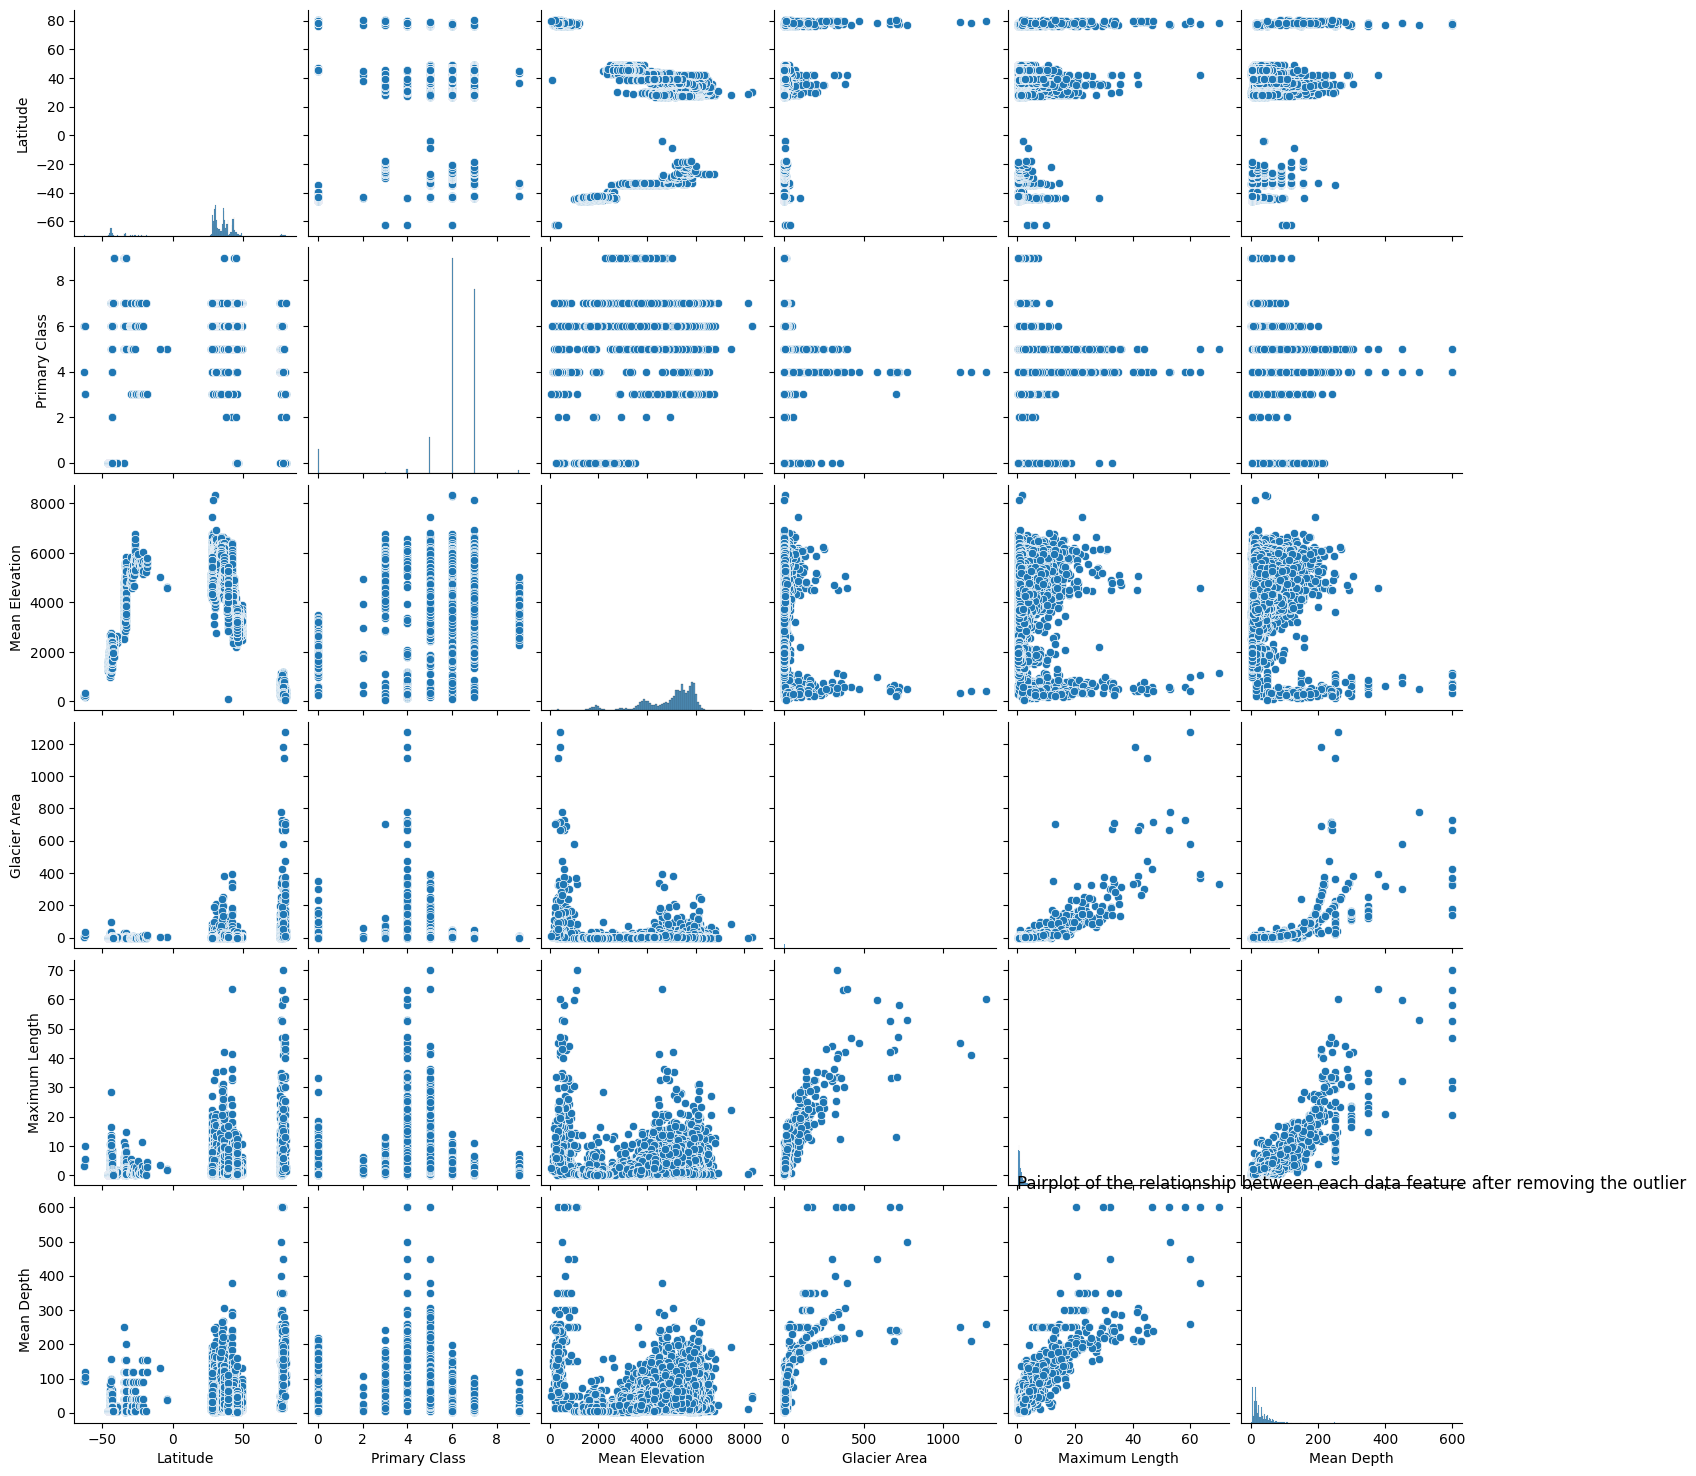

In [52]:
# Figure 7: Plot the pari plot again after removing the outlier to see if there are trends that were missed the first time.
sns.pairplot(glaciers)
plt.title("Pairplot of the relationship between each data feature after removing the outlier")

This confirms my suspicion that there are most likely at least 3 clusters and potentially more in this data. Multiple of the plots show clear differntiation of three classes. It is very evident in the Latitude column where there are three latitudinally distinct clusters.

# Data Pre-Processing

The first step here will be to scale all of the numeric columns to a uniform distribution using the quantile scaler. This will place everything on the same scale and hopefully help to make the machine learning algorithms run better. I excluded categorical columns such as Glacier ID, Political Unit, and Name which should remain unchanged here as well as excluded Latitude and Longitude even though they are numeric.

In [53]:
# Columns that should not be transformed because they will be encoded instead
excluded_columns = ["Primary Class", "Accumulation Orientation"]

# Select numeric columns that are not excluded
numeric_columns = glaciers.select_dtypes(include=["float64", "int64"]).columns
columns_to_transform = [col for col in numeric_columns if col not in excluded_columns]

# Apply QuantileTransformer
qt = QuantileTransformer(output_distribution='uniform', random_state=42)

# Create a copy of the glaciers DataFrame to store scaled values
scaled_glaciers = glaciers.copy() # Create scaled_glaciers here

scaled_glaciers[columns_to_transform] = qt.fit_transform(glaciers[columns_to_transform])

scaled_glaciers.head()

Latitude  Primary Class  Mean Elevation  Glacier Area  Maximum Length  \
694  0.000019            3.0        0.000416      0.993071        0.966767   
760  0.000000            4.0        0.000472      0.960744        0.924625   
761  0.000000            6.0        0.000472      0.928572        0.928929   
762  0.000000            6.0        0.000959      0.986288        0.972973   
763  0.000000            3.0        0.002000      0.994778        0.991763   

     Mean Depth Accumulation Orientation  
694    0.988989                        N  
760    0.978478                       NW  
761    0.978478                        W  
762    0.978478                        W  
763    0.984985                        W

The next step in pre-processing that I am going to do is One-Hot encoding for the categorical variables in order to maximize their structure for machine learning. I will One-Hot encode, Accumulation orientation only because I am going to remove the primary class from the clustering since I want to be able to visualize the data based on these classes and see what trends I can learn. This will ensure that they are in a form that will be approriate for the Machine learning algorithms to read effectively.

In [54]:
# Define map for the primary class
primary_class_mapping = {
    0: "Miscellaneous",
    1: "Continental Ice Sheet",
    2: "Ice Field",
    3: "Ice Cap",
    4: "Outlet Glacier",
    5: "Valley Glacier",
    6: "Mountain Glacier",
    7: "Glacieret and Snowfield",
    8: "Ice Shelf",
    9: "Rock Glacier"
}

# Map "Primary Class"
scaled_glaciers['Primary Class'] = scaled_glaciers['Primary Class'].map(primary_class_mapping)

# Columns to encode
columns_to_encode = ['Accumulation Orientation']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the selected columns
encoded_features = encoder.fit_transform(scaled_glaciers[columns_to_encode])

# Create a DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=scaled_glaciers.index)

# Combine the encoded columns with the rest of the DataFrame
scaled_glaciers_encoded = pd.concat([scaled_glaciers.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the first few rows of the updated DataFrame
scaled_glaciers_encoded.head()

# Drop the primary class because we don't want to custer with it
glaciers_ml = scaled_glaciers_encoded.drop(columns=['Primary Class'])


Ok now the dataset is ready to process!

We have over 50,000 glaciers to work with, so this section may take a bit of time.

# KMeans

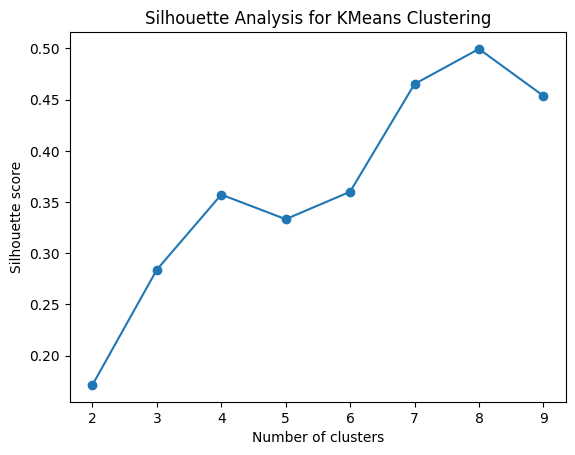

CPU times: user 3min 57s, sys: 3min 2s, total: 6min 59s
Wall time: 2min 40s


In [55]:
# Prompt: Do kmeans clustering on the scaled_glaciers_encoded variable using the scikitlearn package

%%time


# Determine the optimal number of clusters using the silhouette score
kmeans_percentiles = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(glaciers_ml)
    kmeans_percentiles.append(silhouette_score(glaciers_ml, kmeans.labels_))


# Figure 8: Silhouette score versus the inertia of each cluster. Shows what the
# Optimal number of clusters is for this dataset.
plt.plot(range(2, 10), kmeans_percentiles, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for KMeans Clustering')
plt.show()

# Apply KMeans clustering with optimal number of clusters
optimal_k = np.argmax(kmeans_percentiles) + 2 # Add 2 to adjust for the range in the loop
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(glaciers_ml)
kmeans_results = pd.DataFrame()
kmeans_results['kmeans_cluster'] = kmeans.labels_

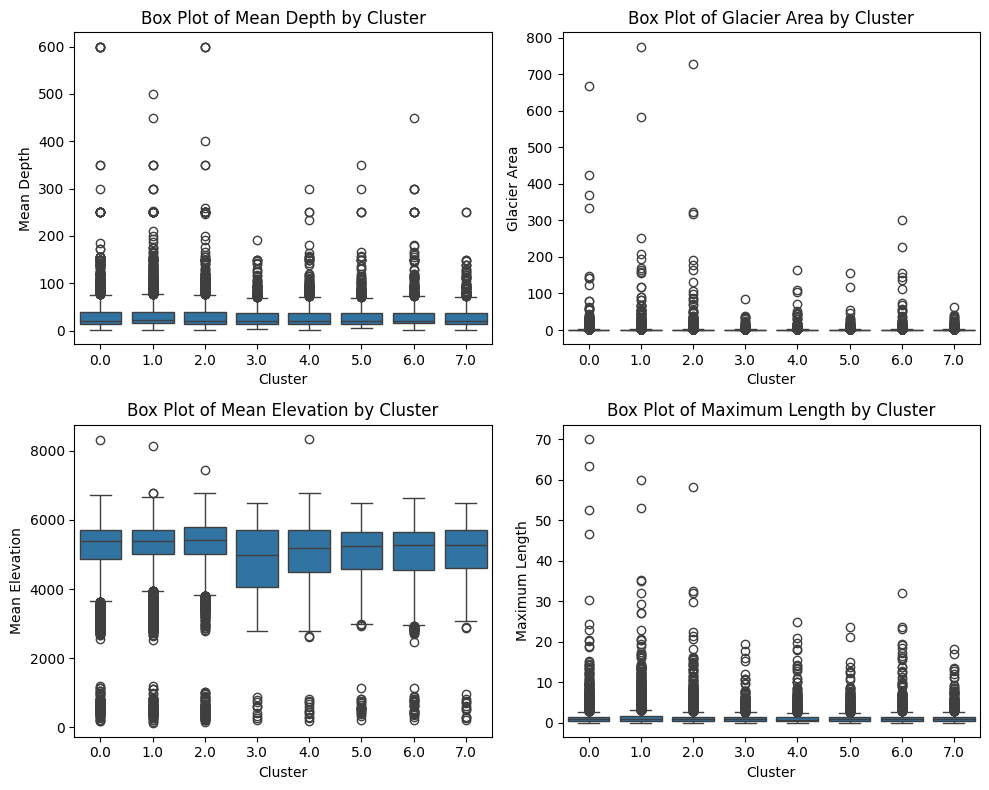

In [56]:
# prompt: Plot a box plot for the clusters for the mean elevation, glacier area, mean depth and maximum length of the glacier

# Figure 9: Plot of the clusters comparing the numeric data for each cluster.
plt.figure(figsize=(10, 8))
features_to_plot = ['Mean Depth', 'Glacier Area', 'Mean Elevation', 'Maximum Length']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=pd.concat([glaciers, kmeans_results], axis=1))
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

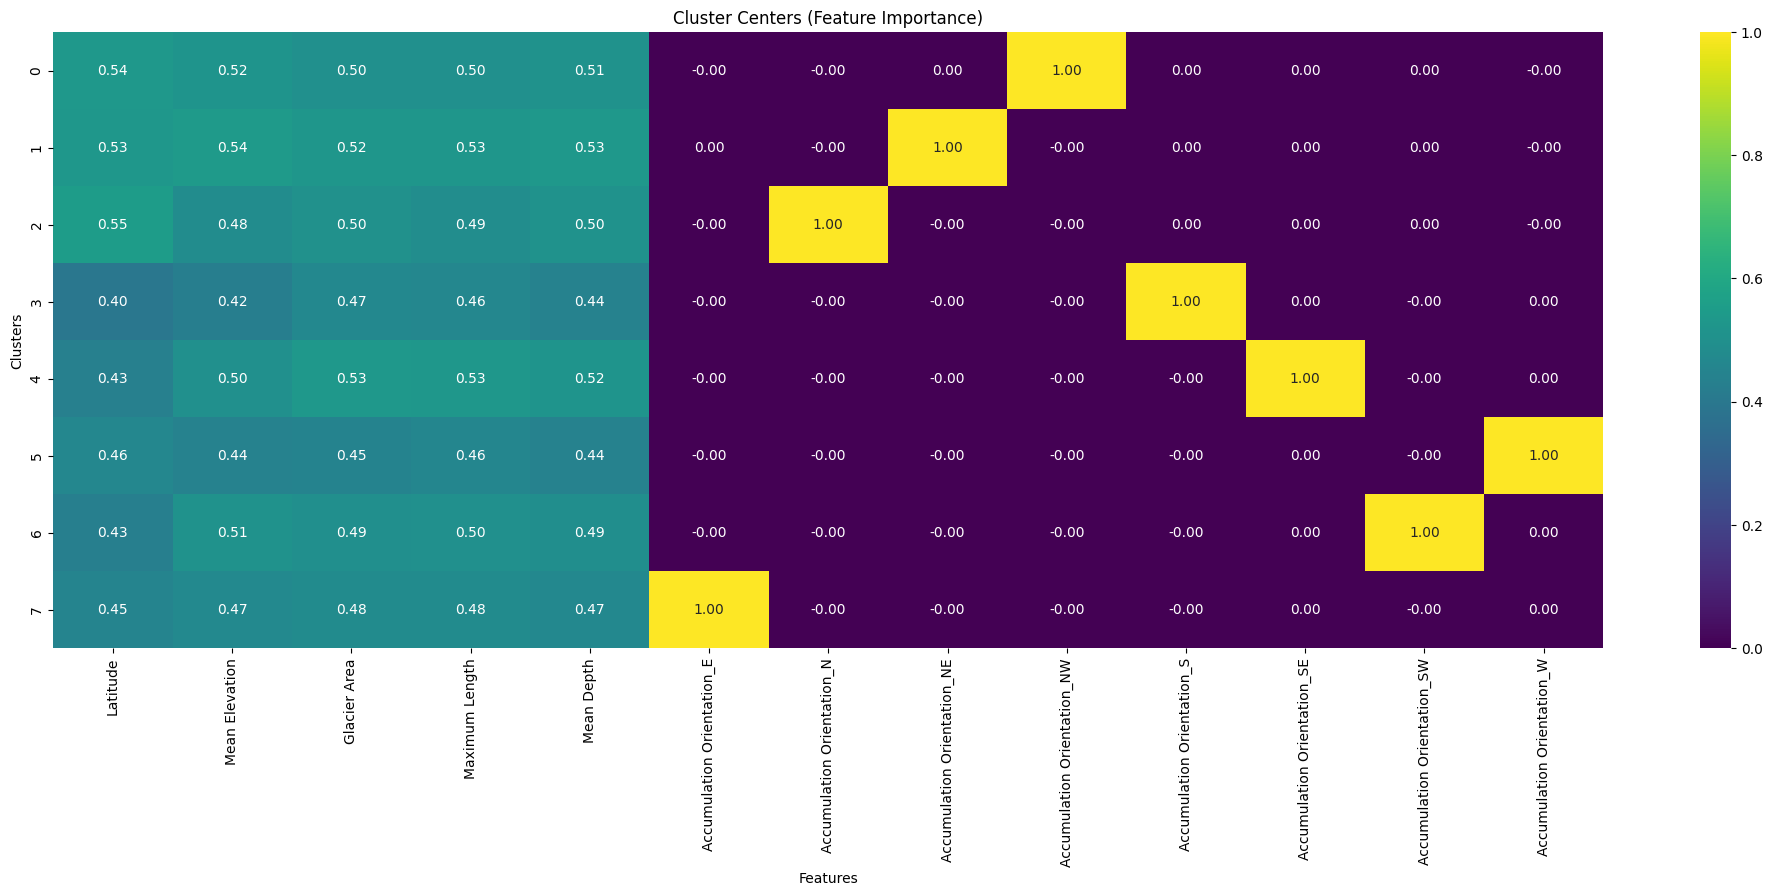

In [57]:
# Ensure the input data to KMeans matches the feature set
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=glaciers_ml.columns[:kmeans.cluster_centers_.shape[1]]  # Match the shape
)

# Figure 10: Heatmap of the cluster center importance for each of the variables.
# The importance of each of the variables was weighted fairly evenly.
plt.figure(figsize=(25, 8))
sns.heatmap(cluster_centers, cmap='viridis', annot=True, fmt=".2f")
plt.title("Cluster Centers (Feature Importance)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

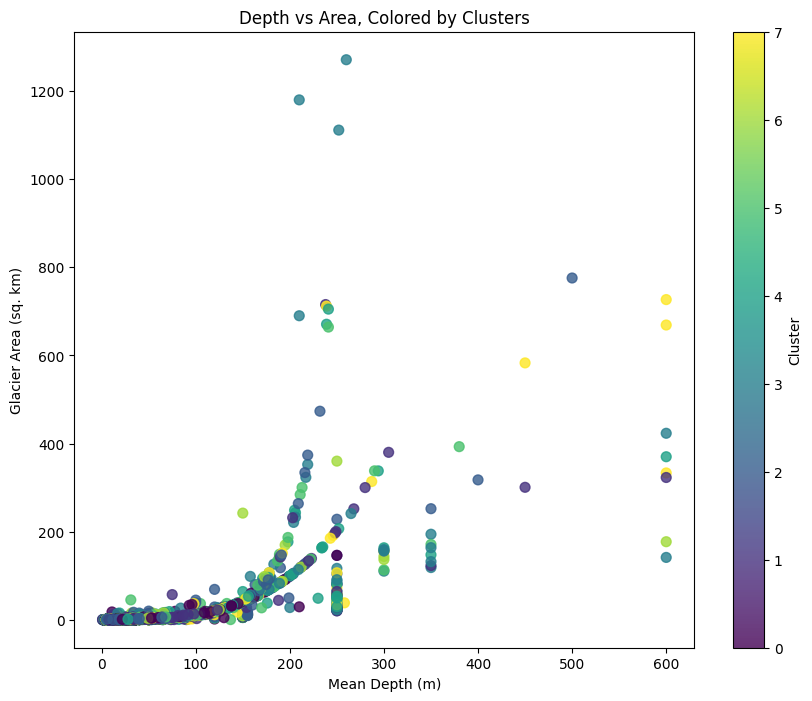

In [58]:
glaciers['kmeans_cluster'] = kmeans.labels_

# Figure 11: Scatter plot of the Depth vs Glacier area showing the clusters.
plt.figure(figsize=(10, 8))
plt.scatter(
    glaciers['Mean Depth'],
    glaciers['Glacier Area'],
    c=glaciers['kmeans_cluster'],
    cmap='viridis',
    s=50,
    alpha=0.8,
)
plt.colorbar(label='Cluster')  # Add a colorbar to show cluster numbers
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Depth vs Area, Colored by Clusters')
plt.show()

Text(0.5, 1.0, 'Latitude vs Mean Elevation, Colored by Clusters')

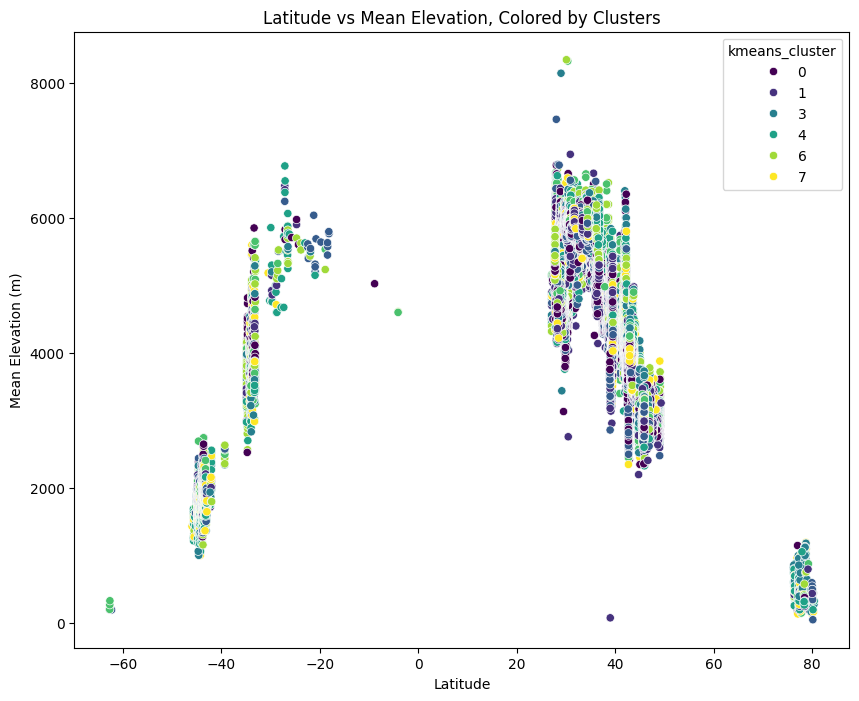

In [59]:
# Figure 12: Plot of the Latitude vs the mean elevation with colors corresponding to the clusters.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Latitude', y='Mean Elevation', hue='kmeans_cluster', data=glaciers, palette='viridis')
plt.xlabel('Latitude')
plt.ylabel('Mean Elevation (m)')
plt.title('Latitude vs Mean Elevation, Colored by Clusters')

Overall I am not seeing much in these plots of 8 clusters. The points appear to be mostly randomly distributed depsite the high silhouette score that I got. I am going to re-run the clustering using only 3 clusters to see what happens then.

In [60]:
# Cluster the data again with 3 clusters to see the data. This is what i think will work the best.
%%timeit
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(glaciers_ml)
glaciers['kmeans_cluster_3'] = kmeans3.labels_

116 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


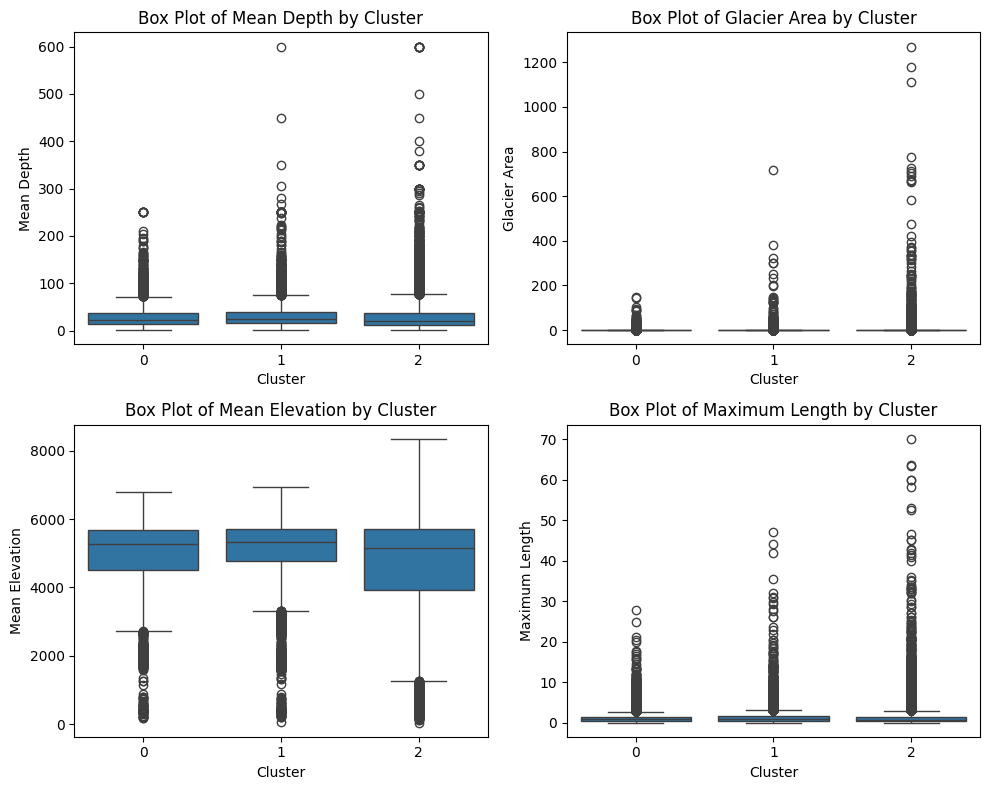

In [61]:
# Figure 13: Plot of the clusters comparing the the numeric data using only 3 clusters.
plt.figure(figsize=(10, 8))
features_to_plot = ['Mean Depth', 'Glacier Area', 'Mean Elevation', 'Maximum Length']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='kmeans_cluster_3', y=feature, data=glaciers)
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

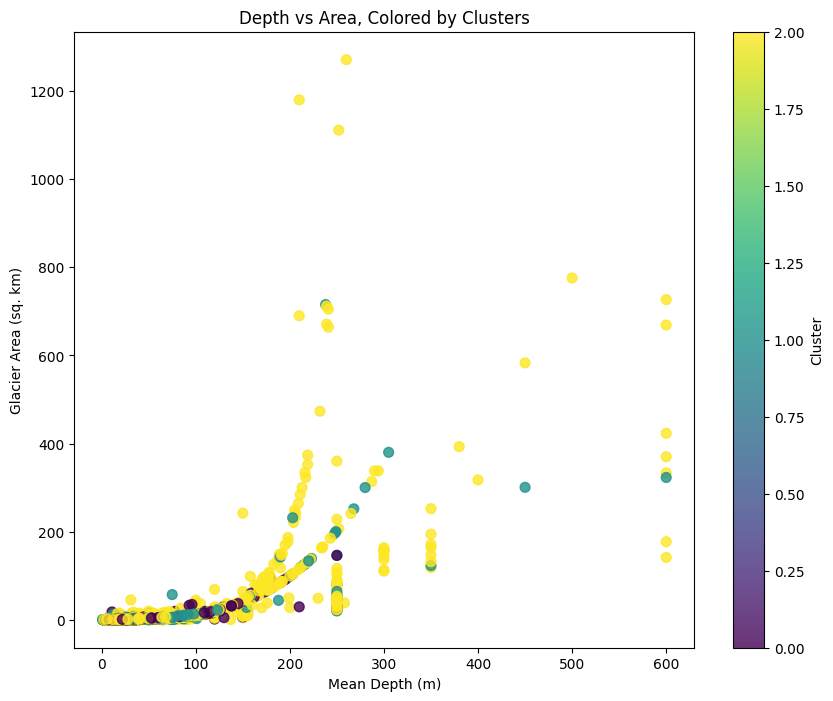

In [62]:
# Figure 14: Scatter plot of the Depth vs Glacier area showing the 3 clusters.
plt.figure(figsize=(10, 8))
plt.scatter(
    glaciers['Mean Depth'],
    glaciers['Glacier Area'],
    c=glaciers['kmeans_cluster_3'],
    cmap='viridis',
    s=50,
    alpha=0.8,
)
plt.colorbar(label='Cluster')  # Add a colorbar to show cluster numbers
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Depth vs Area, Colored by Clusters')
plt.show()

Text(0.5, 1.0, 'Latitude vs Mean Elevation, Colored by Clusters')

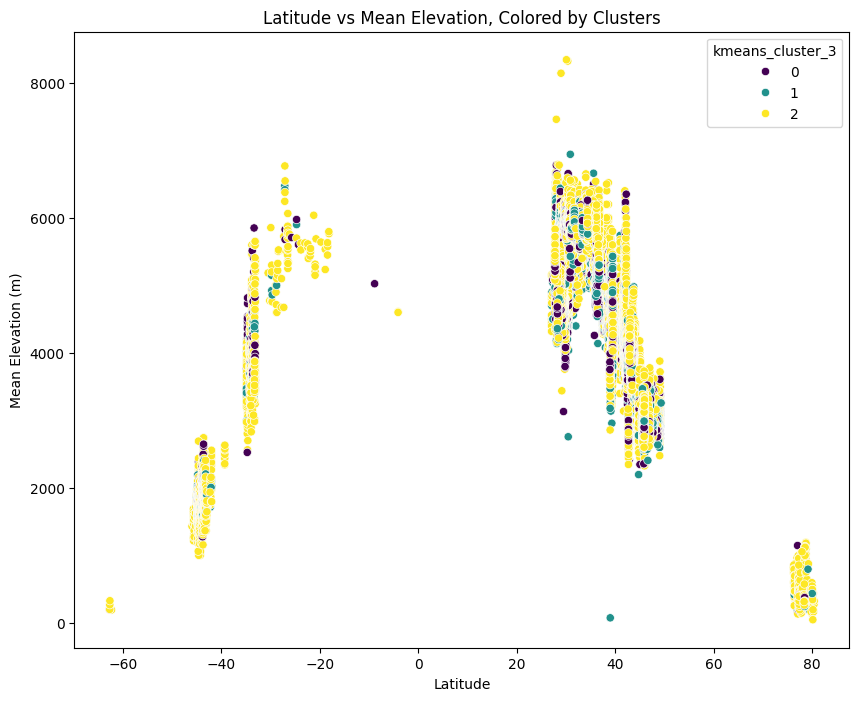

In [63]:
# Figure 15: Plot of the Latitude vs the mean elevation with colors corresponding to the clusters.
# This figure uses only 3 clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Latitude', y='Mean Elevation', hue='kmeans_cluster_3', data=glaciers, palette='viridis')
plt.xlabel('Latitude')
plt.ylabel('Mean Elevation (m)')
plt.title('Latitude vs Mean Elevation, Colored by Clusters')

Overall this was farily dissapointing. The clustering did not appear to work with either the optimal number of clusters as determined by the silhouette score, or with only 3 clusters which is what I determined would be the best. I am not really sure why this was the case as I did all the necessary pre-processing steps. I suspect that this may be a case of it just doesn't work every time the way you want it to. I will try it in lower dimensional space later as well, but for now I am not super pleased with these results. It is what it is I guess.

Text(0.5, 1.0, 'Accumulation Orientation vs Glacier Area, Colored by Clusters')

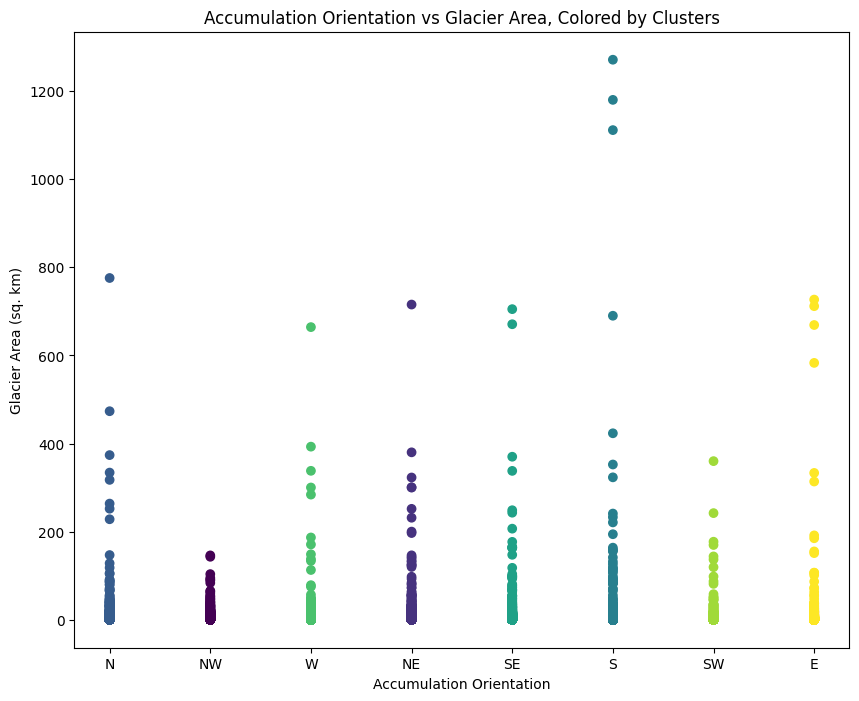

In [64]:
# Figure 16: Scatter plot of the orientation direction vs glacier area colored by cluster.
# This figure shows why 8 clusters is the optimal number for this dataset.
plt.figure(figsize=(10,8))
plt.scatter(glaciers['Accumulation Orientation'], glaciers['Glacier Area'], c=glaciers['kmeans_cluster'], cmap='viridis')
plt.xlabel('Accumulation Orientation')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Accumulation Orientation vs Glacier Area, Colored by Clusters')

Ah, well this explains the reasoning for the poor clustering before. Maybe I will try it without this data included because I am not sure that this really means anything. I think that what is happening is the model is giving full credit to each of the different columns that store this since they are all storing values of 1 and therefore it is resulting a classification based only on these. Let's try it again without the orientation information.

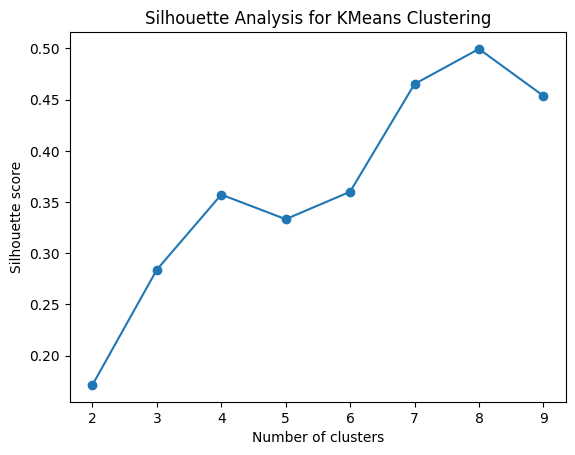

CPU times: user 3min 59s, sys: 3min 3s, total: 7min 2s
Wall time: 2min 42s


In [65]:
# prompt: Perform k-means clustering for the optimal number of clusters similar to above using the glaciers_ml code after removing any column that starts with "Accumulation_Orientation"
%%time

# Drop columns starting with "Accumulation_Orientation"
glaciers_ml2 = glaciers_ml.drop(columns=[col for col in glaciers_ml.columns if col.startswith('Accumulation_Orientation')])

# Determine the optimal number of clusters using the silhouette score
kmeans_percentiles2 = []
for i in range(2, 10):
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans2.fit(glaciers_ml2)
    kmeans_percentiles2.append(silhouette_score(glaciers_ml2, kmeans2.labels_))

# Figure 17: Silhoueete score vs inertia for the data after removing the orientation data.
plt.plot(range(2, 10), kmeans_percentiles2, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for KMeans Clustering')
plt.show()

# Apply KMeans clustering with the optimal number of clusters
optimal_k = np.argmax(kmeans_percentiles2) + 2
kmeans2 = KMeans(n_clusters=optimal_k, random_state=42)
kmeans2.fit(glaciers_ml2)
glaciers['kmeans_cluster_2'] = kmeans2.labels_

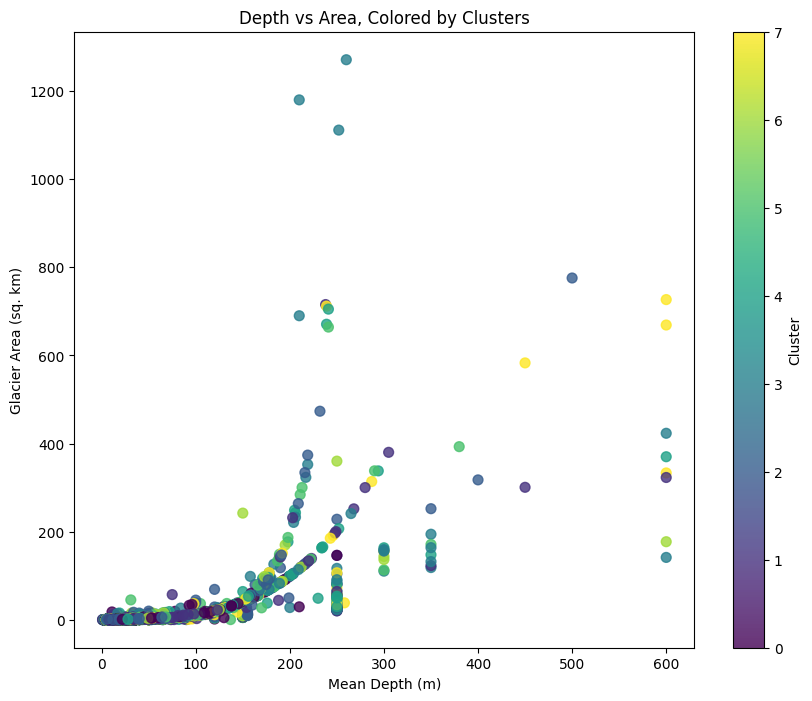

In [66]:
# Figure 18: Scatter plot of the Depth vs Glacier area showing the 2 clusters.
plt.figure(figsize=(10, 8))
plt.scatter(
    glaciers['Mean Depth'],
    glaciers['Glacier Area'],
    c=glaciers['kmeans_cluster_2'],
    cmap='viridis',
    s=50,
    alpha=0.8,
)
plt.colorbar(label='Cluster')  # Add a colorbar to show cluster numbers
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('Depth vs Area, Colored by Clusters')
plt.show()

This is still not informative of anything really, the clusters are unblananced. I thought more of the bottom would be one cluster and more of the top another. So I don't know what to think of this model.

# DBSCAN

In [67]:
# Prompt: Do DBSCAN clustering on scaled_glaciers_encoded and scale it using silhoutte scoring

%%time

# Find optimal epsilon using silhouette score
dbscan_percentiles = []
for eps in np.linspace(0.1, 1, 10):
    dbscan = DBSCAN(eps=eps, min_samples=5) # Adjust min_samples as needed
    dbscan.fit(glaciers_ml)
    if len(set(dbscan.labels_)) > 1:  # Check for more than one cluster
        dbscan_percentiles.append(silhouette_score(glaciers_ml, dbscan.labels_))
    else:
        dbscan_percentiles.append(-1)  # Append -1 if only one cluster

optimal_eps = np.linspace(0.1, 1, 10)[np.argmax(dbscan_percentiles)]

# Apply DBSCAN with optimal epsilon
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(glaciers_ml)

# Add cluster labels to the glaciers dataframe
glaciers['dbscan_cluster'] = dbscan.labels_

# Print the Silhouette Score
print("Silhouette Score:", silhouette_score(glaciers_ml, dbscan.labels_))

# Print the number of clusters
print("Number of clusters:", len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))

Silhouette Score: 0.49954415873526725
Number of clusters: 8
CPU times: user 8min 20s, sys: 3min 37s, total: 11min 57s
Wall time: 6min 29s


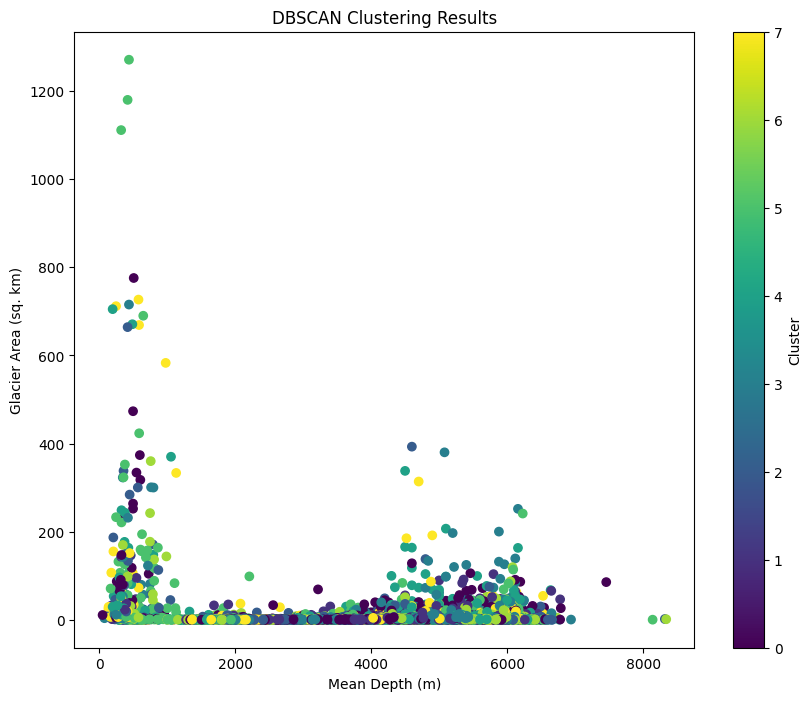

In [68]:
# Figure 19: Plot of the Mean Depth vs. Glacier Area DBSCAN results plotted by the cluster
plt.figure(figsize=(10, 8))
plt.scatter(glaciers['Mean Elevation'], glaciers['Glacier Area'], c=glaciers['dbscan_cluster'], cmap='viridis')
plt.xlabel('Mean Depth (m)')
plt.ylabel('Glacier Area (sq. km)')
plt.title('DBSCAN Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

It is interesting that the results of the DBSCAN agree with the K-means. They both predict 8 clusters and both have a silhouette score of 0.5, so their agreement gives me some confidence that possibly there are truly 8 clusters however I still have trouble visualizing the data so I am not entirely sure what I am looking at still.

# PCA

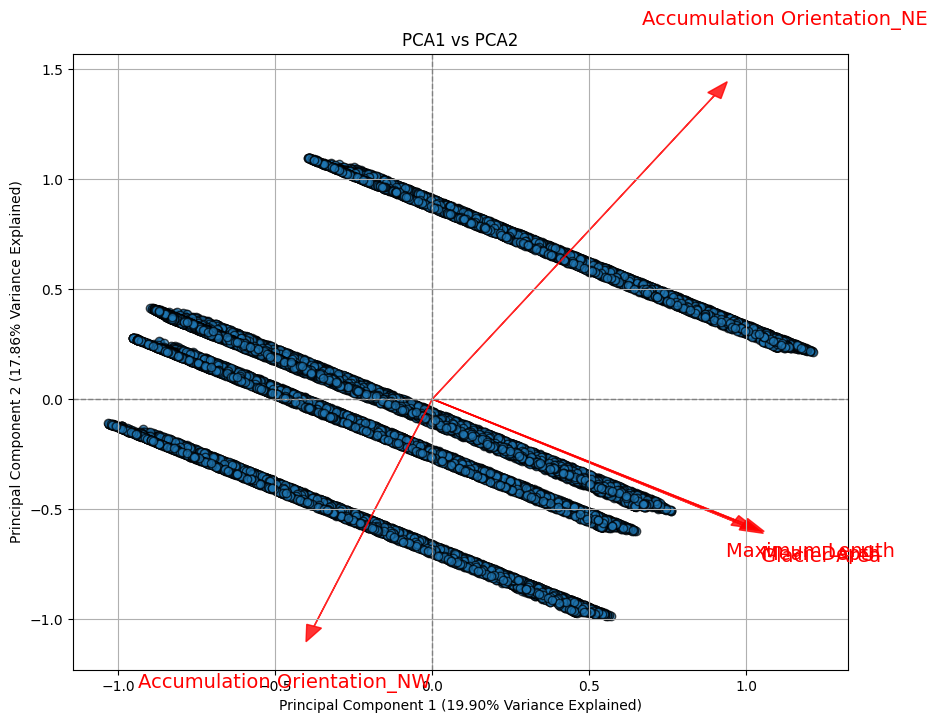

CPU times: user 431 ms, sys: 733 ms, total: 1.16 s
Wall time: 275 ms


In [69]:
# Perform PCA

%%time

pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(glaciers_ml)

# Extract explained variance and eigenvectors (loadings)
explained_variance = pca.explained_variance_ratio_
eigenvectors = pca.components_

# Figure 20: Scatter plot of PCA1 vs PCA2 of full data.
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance Explained)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance Explained)")
plt.title("PCA1 vs PCA2")

# Calculate eigenvector magnitudes
eigenvector_magnitudes = np.sqrt(eigenvectors[0, :]**2 + eigenvectors[1, :]**2)

# Sort features by their contributions
sorted_indices = np.argsort(eigenvector_magnitudes)[::-1]
top_features = sorted_indices[:5]  # Select top 5 features

# Overlay only the top eigenvectors
for i in top_features:
    plt.arrow(0, 0, eigenvectors[0, i] * 2, eigenvectors[1, i] * 2, color='r', alpha=0.8, head_width=0.05)
    plt.text(eigenvectors[0, i] * 2.5, eigenvectors[1, i] * 2.5, glaciers_ml.columns[i],
             color='r', fontsize=14, ha='center', va='center')


# Add grid for better visualization
plt.grid()
plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')

plt.show()



The accumulation orientation encoded data appears to be having a really large impact on the data. I am going to try running this again without that encoded data to see what happens.

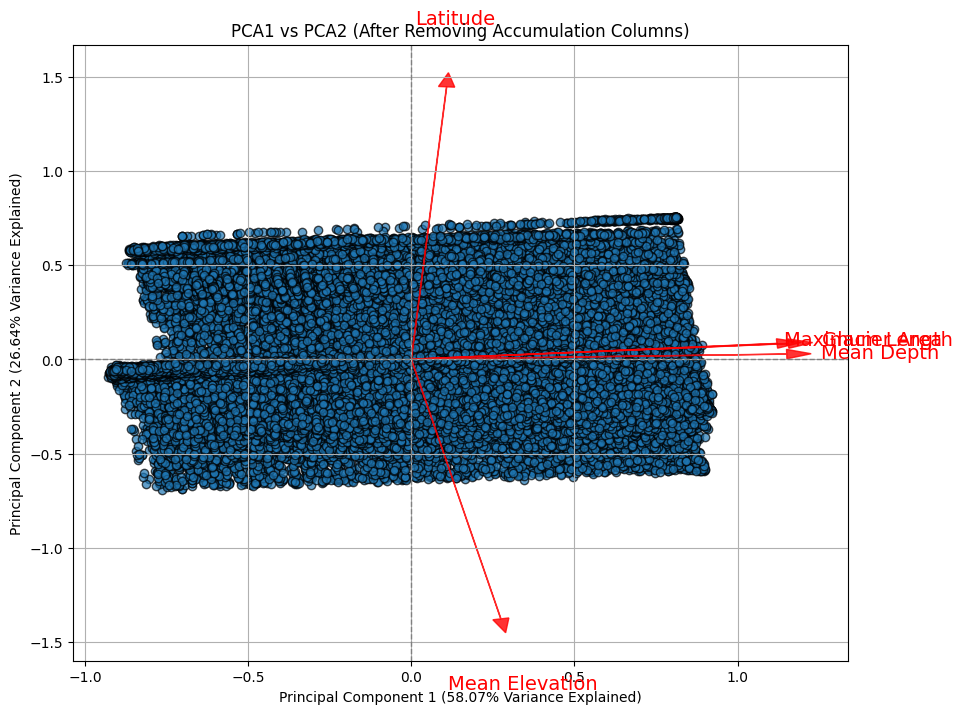

In [70]:
# prompt: Remove the columns from glaciers_ml that start with "Accumulation" then do a PCA and make a plot like in the code cell above

# Remove columns starting with "Accumulation"
glaciers_ml = glaciers_ml.drop(columns=[col for col in glaciers_ml.columns if col.startswith('Accumulation')])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(glaciers_ml)

explained_variance = pca.explained_variance_ratio_
eigenvectors = pca.components_

# Figure 21: PCA1 vs PCA2 plotted after removing the accumulation orientation from the data
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance Explained)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance Explained)")
plt.title("PCA1 vs PCA2 (After Removing Accumulation Columns)")

# Calculate eigenvector magnitudes and sort features by their contributions
eigenvector_magnitudes = np.sqrt(eigenvectors[0, :]**2 + eigenvectors[1, :]**2)
sorted_indices = np.argsort(eigenvector_magnitudes)[::-1]
top_features = sorted_indices[:5]

# Overlay the top eigenvectors
for i in top_features:
    plt.arrow(0, 0, eigenvectors[0, i] * 2, eigenvectors[1, i] * 2, color='r', alpha=0.8, head_width=0.05)
    plt.text(eigenvectors[0, i] * 2.5, eigenvectors[1, i] * 2.5, glaciers_ml.columns[i],
             color='r', fontsize=14, ha='center', va='center')

plt.grid()
plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')
plt.show()

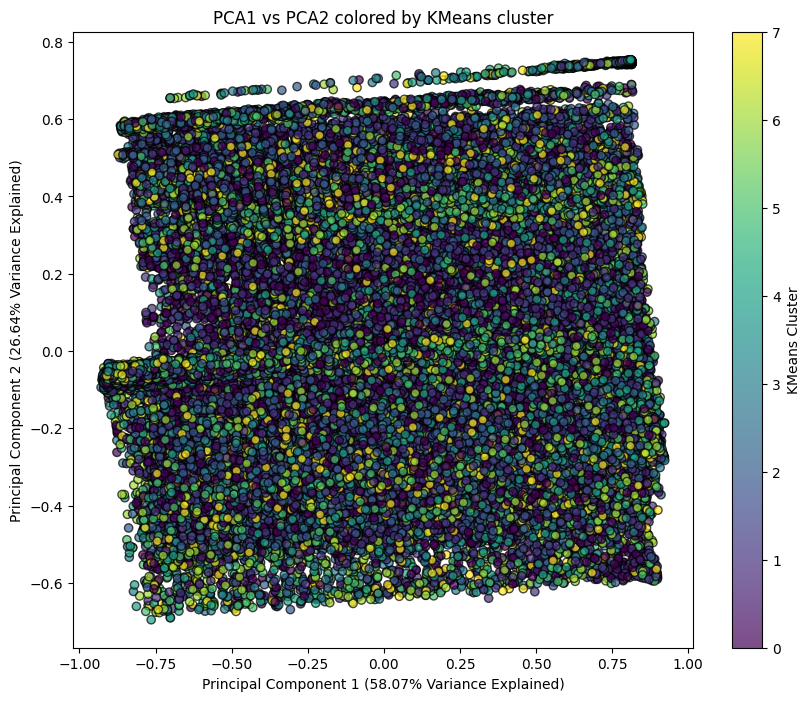

In [71]:
# Figure 22: Plot of the PCA1 versus PCA2 with colors corresponding to the 8 k-means clusters from the original clustering exercise.
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_results['kmeans_cluster'], cmap='viridis', alpha=0.7, edgecolor='k')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance Explained)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance Explained)")
plt.title("PCA1 vs PCA2 colored by KMeans cluster")
plt.colorbar(label='KMeans Cluster')
plt.show()

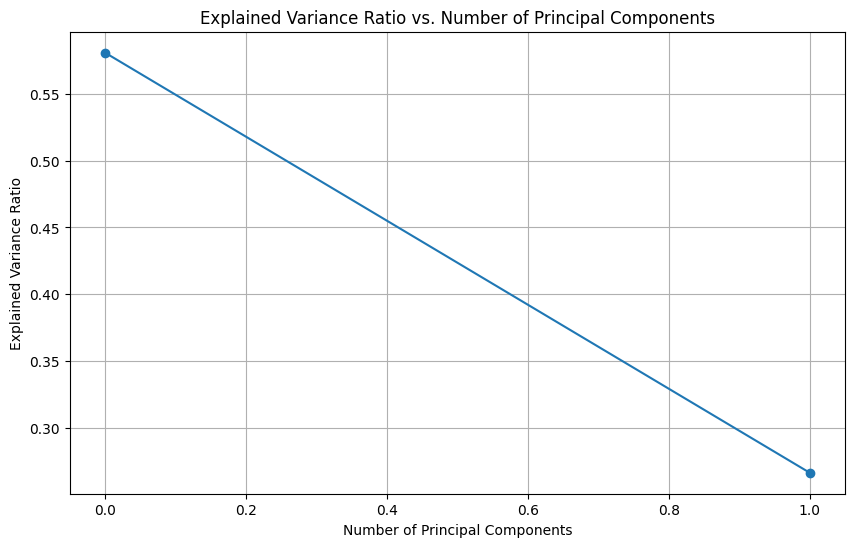

In [72]:
# Figure 23: Explained variance ratio for the first two principal compnents accounting for 84% of the total variability.
plt.figure(figsize=(10, 6))
plt.plot(explained_variance[:10], marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs. Number of Principal Components")
plt.grid(True)
plt.show()

In the PCA above I got interesting results where the first principal component was primarily explained by the Mean Depth, Maximum Length and Glacier Area. The second component was mostly explained by the opposition of the accumulation orientation either being the northeast or the northwest. I am confused because this is similar to what it was doing last time. I decided to remove the orientation fields and then the PCA looks quite different. After removing the orientation fields the total varince of PCA1 accounts for 58% of the variability and PCA2 accounts for 26.6% of the variability. This is a total of 84% of the variability with just these two principal components down from 5. I tried to plot the PCA1 vs PCA2 with the clusters on it to see if they showed anything and they did not really, they still look completely scattered with no realrepresentation. However it is intersting to note that the latitude varies positively with the second PCA and the elevation varies negatively with the second PCA. These oppose each other which is a predicted relationship from common understanding which I am able to show clearly here.

# Questions

##### Which Method did you like most?

I liked the PCA the most. The problem I had with the clustering is that it is difficult to display them when there are so many different features, the high-dimensional data is not siple to work with. I liked the PCA because it converted the data down into only two dimensions which is easy for my brain to process and was a lot easier to deal with in my opinion. I think that this is dataset dependent though, because I can see that for a dataset that is low-dimensional and contains only 2-3 dimensions I may like the Kmeans clustering the best since it is easy to visualize the cluster centers on a plot that large. I also like PCA because it shows me how the data vary instead of just grouping them. This dataset particularly did not cooperate despite my best efforts to make something out of the different meethods I only really had success with the PCA. Another reason I liked the pCA is because I have seen it most often used and I think that it would be good to know about over the other methods that I tried here.

##### Which method did you like the least?

I overall did not like the DBSCAN. I find the fact that there are so many clusters confusing and even more difficult to understand and visualize than the Kmeans clustering. Also becasue the clusters overlap, I could not begin to understand how to interpret the data. Also I am not sure why but after running the DBSCAN I got a different plot for the same data I plotted earlier and I am not certain why.

##### How did you score these unsupervised models?

I scored the clustering algorithyms using the silhouette scoring method. This was extremely simple to do particulalrly when applying the Google Colab AI tool to help with code writing. I also found this method easy to interpret, a higher value is better and a value close to o means that the clusters overlap significantly. I think that based on my results, both of the clustering algorithms performed equally well (not amazingly) with a silhouette score of 0.5 they did an okay job with 8 clusters. What those clusters are I am still not entirely sure other than the orientation features which appeared to have an unpredictably large influence on the data both in the clustering and the PCA.

For the PCA I analyzed the explained variance of the principal components to determine how well the first two principal components were able to explain the variability of the data. They only accont for about 33% of the variability or 1/3 which tells me that there may be other components which are important beyond the first two.

##### Did the output align with your geologic understanding?

No the data were very surprising to me. I predicted that I would be able to use this data to understand the primary class of glaciers but instead I am completely confounded by the impact of the accumulation orientation. This leaves me with questions like: Is the accumulation orientation actually that large of a predictor and matters that much for classification? Or is that just some artifact of the data that was unpredicted? I am really not sure on this one and don't know how I would check it out. I will say that glaciologists know that in the Northern hemishere the north facing glaciers will fare better over time because they get less sun in the winter whereas in the southern hemisphere the south facing sloped glaciers do better. What I am not sure about is that the 8 individual cardinal directions that I looked at here are as important as the model make them out to be. This is kind of cool though because it leaves me with a new question to look into, something I did not expect in the data is actually more intersting to me that proving what I already knew. For example in the last PCA I ran the elevation and latitude were opposing each other, this is also common knowledge, as one goes up in laitude (towards the poles) then glaciers can survive better at lower elevations. So in some regards the model predicted exactly what my glaciological understanding is and in others it completely surprised me. I even looked at doing the k-means without the data for the orientation but that was not much better. Overall very intersting here, leaves me with more questions than when I started which means I have achieved my goals!

##### What did you wnat to learn more about?

I think that I really liked the PCA method, and this is something I would like to improve my skills with. I have learned this three times before in the past, and each time it has made slightly more sense (I remember the first time I learned it I was completely lost and had absolutely no clue what I was learning about). But at this point I am starting to get an understanding of when to use PCA, how it can benefit my research (related to when this is even useful) and how I can interpret the results. I think that I will keep learning about this method moving forward as I have also seen that it is extremely common in a lot of the literature. Another method which I did not explore here but I'd like to learn more about is the Gaussian Mixture modelling, because this seems interesting!

##### Did you pre-process your data?

Yes, I did a lot of pre-processing to get the data into a specific structure which I thought would help the machine learning models run better. I would have to run these again without some of this pre-processing to compare, but I will mention one thing, before I settled on the data that I ran here, I did not remove the latitude from the dataset, but I also did not scale it because I did not think I needed to and it felt weird to scale such a value. The results I got from that initial test were very different from what I am presenting here. I got 4 clusters, but the latitude was the only factor that mattered for the clustering, so since there were 4 clusters of the latitude data, it overpowered all of the other scaled data which was between 1-2. This initial mistake on my part demonstrated to me the importance of proper pre-proccessing.

##### What was a decision you were most unsure about?

I am most unsure about the DBSCAN method. It is still really confusing to me and I do not know how to interpret it even after reading more about it recently. I just can't wrap my head around it. The k-means and the PCA I can understand now, but the DBSCAN is still super uncertain. I probably would not apply this in the future and would try something else like Gaussian Mixture Modeeling instead.